In this document we&rsquo;ll work through a simple approach to estimating
Constant Frisch Elasticity (CFE) demand systems.

There are two prerequisites; the first is the `CFEDemands` python
module, which can be installed with a simple:



In [13]:
!pip install -r requirements.txt

The second prerequisite is a dataset including detailed information on
household expenditures and characteristics.  The structure of that
dataset is detailed in the next section.



## Data



Consider the case in which the data are saved in a google sheet; we&rsquo;ll
turn data from these into `pandas` dataframes.  
There are limits on the allowable size of google sheets (5 million
cells), so if your dataset is larger than this you&rsquo;ll need some other
mechanism to get your data into such dataframes.  Even in this latter
case you&rsquo;ll want your dataframes to have a structure that matches the
description given below.



### Structure of the Spreadsheet



An example spreadsheet can be found at
[https://docs.google.com/spreadsheets/d/13Ig5hZif-NSHtgkKRp_cEgKXk0lOsdUB2BAD6O_FnRo/](https://docs.google.com/spreadsheets/d/13Ig5hZif-NSHtgkKRp_cEgKXk0lOsdUB2BAD6O_FnRo/).

This spreadsheet consists of three worksheets, labeled &ldquo;Expenditures&rdquo;,
&ldquo;Household Characteristics&rdquo;, &ldquo;Consumption&rdquo;, and &ldquo;FCT&rdquo; respectively.

Each worksheet has the initial three columns labeled &ldquo;j&rdquo;, &ldquo;t&rdquo;, and
&ldquo;m&rdquo;; together these identify an observation uniquely.  The column &ldquo;j&rdquo;
should include a household id; the column &ldquo;t&rdquo; should include an
indicator for the year or period (for those of you with
cross-sectional data these will all take a common value, e.g., 2019);
the column &ldquo;m&rdquo; should be an indicator of &ldquo;market&rdquo;, which may be a
region identifier, or may take a single value (e.g., &ldquo;Malawi&rdquo;).

The triple (j,t,m) will serve as the index of some constructed
dataframes.  It is important not to have **too** many different values
for &ldquo;m&rdquo; (unless you have lots of RAM to play with).

Beyond the first three columns, the &ldquo;Expenditures&rdquo; worksheet should
have one column for each category of expenditures (e.g., &ldquo;Rice&rdquo;, &ldquo;Goat
meat&rdquo;, &ldquo;Millet&rdquo;,&#x2026;).

Beyond the first three columns, the &ldquo;Household Characteristics&rdquo; should
have columns corresponding to different elements of the vector of
observable characteristics $z$.  If the data allow, I recommend
constructing observables that match what I have in the ICRISAT data:
namely numbers of different children by age and sex, along with the
logarithm of total household size (&ldquo;log HSize&rdquo;).



### From Sheet to DataFrame to Result Object



We begin by defining a dictionary that contains the spreadsheet key. 
One is provided for the Indian ICRISAT example that I wish to work
through.



In [1]:
nigeria_data = '17L5cDhXRLNAckP3JvBLTLSYIguFqP2ebMvQLH96c0n4'
nigeria_production = '1kG_fVBmj9EEF9LOwxN30HBxkQENOoWeQjVPYzMJe3b4-8DA'
nigeria_consumption = '1Gzu0g2Tjp0heKYk-r5l7gVJk93k2_mHgWOtZMVkqSGI'

With the spreadsheet defined , grab it and define a couple of
dataframes. (Sheets should be shared with `students@eep153.iam.gserviceaccount.com`):



In [14]:
import pandas as pd
import numpy as np
import sys
from eep153_tools.sheets import read_sheets

expend = read_sheets(nigeria_data,sheet='Expenditures')
expend.columns.name = 'i'
                 
# Change 'ICRISAT' to key of your own sheet in Sheets, above
hh_char = read_sheets(nigeria_data,sheet="HH Characteristics")
hh_char.columns.name = 'k'

# Assume a single market: (Comment this out to make each village its own market)
hh_char['m'] = 1
expend['m'] = 1

# x may have duplicate columns
expend = expend.groupby('i',axis=1).sum()
expend = expend.apply(lambda x: pd.to_numeric(x,errors='coerce'))
expend = expend.replace(0,np.nan)

# Take logs of expenditures; call this y
log_expend = np.log(expend.set_index(['j','t','m']))
           
hh_char.set_index(['j','t','m'],inplace=True)

Key available for students@eep153.iam.gserviceaccount.com.
Key available for students@eep153.iam.gserviceaccount.com.


Also a dataframe of log expenditures $y$ with a similarly simple
structure.  Note that any expenditures of zero are dropped and
replaced with a missing value indicator.



In [15]:
log_expend.head()

,,i,"(Cocoyam, Spinach, etc)",Agricultural eggs,Animal fat,Apples,Avocado pear,Baby milk powder,Bananas,Beef,Beer (local and imported),Biscuits,...,Sweet Potatoes,Tea,Tomato puree(canned),Tomatoes,Watermelon,Wheat flour,White beans,Wild game meat,Yam flour,Yam-roots
j,t,m,,,,,,,,,,,,,,,,,,,,,
10001,2010,1,NaN,5.634790,NaN,NaN,NaN,NaN,5.298317,6.214608,6.291569,NaN,...,5.010635,NaN,5.010635,5.010635,NaN,NaN,6.396930,NaN,NaN,7.313220
10002,2010,1,NaN,5.634790,NaN,NaN,NaN,NaN,5.192957,7.090077,7.600902,NaN,...,5.298317,4.941642,5.480639,4.787492,NaN,NaN,5.991465,NaN,NaN,7.090077
10003,2010,1,NaN,5.192957,NaN,NaN,NaN,NaN,4.605170,6.214608,NaN,NaN,...,5.298317,4.094345,4.499810,4.605170,NaN,NaN,4.605170,NaN,NaN,5.991465
10004,2010,1,NaN,5.192957,NaN,NaN,NaN,NaN,4.605170,6.214608,NaN,NaN,...,NaN,3.401197,4.094345,4.605170,NaN,NaN,4.605170,NaN,NaN,5.991465
10006,2010,1,NaN,NaN,NaN,NaN,NaN,NaN,5.703782,5.703782,NaN,NaN,...,NaN,6.476972,NaN,5.991465,NaN,NaN,NaN,NaN,NaN,5.991465


In [56]:
expend = expend.reset_index(drop=True).set_index(['t','j','m']).sort_index()

# Total Expenditures

In [57]:
total_expend = expend.iloc[:, 0:124].sum(axis=1)
total = pd.DataFrame(total_expend)
total = total.rename(columns={0:'Total Expenditures'})
total

Total Expenditures
t    j      m                    
2010 10001  1             20225.0
     10002  1             15365.0
     10003  1              4675.0
     10004  1              4465.0
     10006  1              7565.0
...                           ...
2018 379146 1             31100.0
     379148 1              6410.0
     379151 1             20540.0
     379154 1             22650.0
     379155 1              7550.0

[19141 rows x 1 columns]

In [58]:
expend['Total Expenditures'] = total['Total Expenditures']
expend

i              (Cocoyam, Spinach, etc)  Agricultural eggs  Animal fat  Apples  \
t    j      m                                                                   
2010 10001  1                      NaN              280.0         NaN     NaN   
     10002  1                      NaN              280.0         NaN     NaN   
     10003  1                      NaN              180.0         NaN     NaN   
     10004  1                      NaN              180.0         NaN     NaN   
     10006  1                      NaN                NaN         NaN     NaN   
...                                ...                ...         ...     ...   
2018 379146 1                      NaN             1100.0         NaN     NaN   
     379148 1                    100.0                NaN         NaN     NaN   
     379151 1                      NaN              900.0         NaN     NaN   
     379154 1                    200.0             1200.0         NaN     NaN   
     379155 1                    100.0              950.0         NaN     NaN   

i              Avocado pear  Baby milk powder  Bananas    Beef  \
t    j      m                                                    
2010 10001  1           NaN               NaN    200.0   500.0   
     10002  1           NaN               NaN    180.0  1200.0   
     10003  1           NaN               NaN    100.0   500.0   
     10004  1           NaN               NaN    100.0   500.0   
     10006  1           NaN               NaN    300.0   300.0   
...                     ...               ...      ...     ...   
2018 379146 1           NaN               NaN      NaN     NaN   
     379148 1           NaN               NaN      NaN   700.0   
     379151 1           NaN               NaN    500.0     NaN   
     379154 1           NaN               NaN      NaN  1300.0   
     379155 1           NaN               NaN      NaN  1400.0   

i              Beer (local and imported)  Biscuits  ...    Tea  \
t    j      m                                       ...          
2010 10001  1                      540.0       NaN  ...    NaN   
     10002  1                     2000.0       NaN  ...  140.0   
     10003  1                        NaN       NaN  ...   60.0   
     10004  1                        NaN       NaN  ...   30.0   
     10006  1                        NaN       NaN  ...  650.0   
...                                  ...       ...  ...    ...   
2018 379146 1                        NaN       NaN  ...    NaN   
     379148 1                        NaN       NaN  ...    NaN   
     379151 1                        NaN       NaN  ...    NaN   
     379154 1                        NaN       NaN  ...    NaN   
     379155 1                        NaN       NaN  ...    NaN   

i              Tomato puree(canned)  Tomatoes  Watermelon  Wheat flour  \
t    j      m                                                            
2010 10001  1                 150.0     150.0         NaN          NaN   
     10002  1                 240.0     120.0         NaN          NaN   
     10003  1                  90.0     100.0         NaN          NaN   
     10004  1                  60.0     100.0         NaN          NaN   
     10006  1                   NaN     400.0         NaN          NaN   
...                             ...       ...         ...          ...   
2018 379146 1                   NaN       NaN       500.0          NaN   
     379148 1                  60.0     200.0       150.0          NaN   
     379151 1                 150.0     600.0       600.0        750.0   
     379154 1                   NaN     100.0       200.0          NaN   
     379155 1                   NaN     300.0       200.0          NaN   

i              White beans  Wild game meat  Yam flour  Yam-roots  \
t    j      m                                                      
2010 10001  1        600.0             NaN        NaN     1500.0   
     10002  1        400.0             NaN        NaN     120

## Estimation



With nothing more than this, we can estimate the demand system.  This
happens in two steps.  The first is the &ldquo;reduced form&rdquo; step:



In [4]:
import cfe

result = cfe.Result(y=y,z=z)

Missing dependencies for OracleDemands.


This creates a complicated &ldquo;Result&rdquo; object, with lots of different
attributes.  Note from below that attributes $y$ and $z$ are now defined.



In [5]:
result

<xarray.Result>
Dimensions:           (k: 14, j: 8522, t: 4, m: 1, i: 42)
Coordinates:
  * j                 (j) int64 10001 10002 10003 10004 ... 379151 379154 379155
  * t                 (t) int64 2010 2012 2015 2018
  * m                 (m) int64 1
  * i                 (i) <U36 '(Cocoyam, Spinach, etc)' ... 'Yam-roots'
  * k                 (k) <U7 'M 0-3' 'M 4-8' 'M 9-13' ... 'F 31-50' 'F 51+'
Data variables: (12/20)
    alpha             object None
    beta              object None
    delta             object None
    prices            object None
    characteristics   (k, j, t, m) float64 0.0 1.0 1.0 1.0 ... nan nan nan 0.0
    loglambdas        object None
    ...                ...
    se_beta           object None
    se_alpha          object None
    se_a              object None
    y                 (i, j, t, m) float64 nan nan nan nan ... nan nan nan nan
    logp              object None
    z                 (k, j, t, m) float64 0.0 1.0 1.0 1.0 ... nan nan nan 0.0
Attributes:
    firstround:            2010
    min_proportion_items:  0.125
    min_xproducts:         30
    all_tm:                True
    common_alpha:          True
    useless_expenditures:  False
    stderr_tol:            0.01
    indices:               Indices(j='j', t='t', m='m', i='i', k='k')
    iterate:               False
    verbose:               False

### First step of Estimation



Recall that there are two steps to estimation; the first step
involves estimating the &ldquo;reduced form&rdquo; linear regression 
$$
y_{it}^j = {a}_{it} + \delta_i'{z}^j_t + \epsilon_{it}^j.
$$

The Result class has code to estimate this in one line:



In [6]:
result.get_reduced_form()

After running this we can examine the estimated coefficients $\delta$:



In [7]:
result.delta.to_dataframe().unstack('k')

delta                                \
k                                        M 0-3     M 4-8    M 9-13   M 14-18   
i                                                                              
(Cocoyam, Spinach, etc)              -0.016940  0.045847 -0.005505 -0.017215   
Agricultural eggs                     0.034552  0.096835  0.018018  0.053636   
Bananas                               0.087191  0.014969  0.041125  0.074841   
Beef                                  0.031357  0.040075  0.022819  0.067268   
Beer (local and imported)             0.010837  0.067073 -0.007325 -0.037233   
Bread                                 0.003213  0.077405  0.035565  0.076229   
Brown beans                           0.042174  0.095950  0.089248  0.078895   
Chicken                              -0.065475  0.076064 -0.048039 -0.016739   
Chocolate drinks                      0.084639  0.007797  0.027564  0.063775   
Cocoyam                              -0.013853  0.025191  0.013763  0.077353   
Condiments,(salt,spices,pepper, etc)  0.038482  0.054137  0.052416  0.074748   
Fish-Dried                            0.025389  0.008995  0.018051  0.049836   
Fish-Fresh                           -0.083074 -0.046422 -0.043543  0.036876   
Fish-Frozen                           0.004668  0.017948  0.015238  0.062393   
Fish-Smoked                           0.017261  0.052857  0.024050  0.055302   
Garden eggs/egg plant                 0.024858  0.020383  0.011424  0.022445   
Gari -Yellow                          0.002290  0.081697  0.035888  0.063270   
Gari-White                            0.040985  0.027907  0.046767  0.056030   
Goat                                  0.036303 -0.007823  0.010706  0.084854   
Groundnut oil                         0.045383  0.033797  0.028083  0.051483   
Malt drinks                           0.061383  0.036615  0.016848  0.064526   
Milk powder                           0.093165 -0.016594  0.044680  0.074568   
Milk tinned (unsweetened)             0.061620  0.047417 -0.004631  0.034586   
Okra-fresh                            0.030216  0.061569  0.040625  0.040731   
Onions                                0.047570  0.064337  0.031032  0.076838   
Orange/tangerine                      0.071349  0.054287  0.070500  0.077146   
Other vegetables (fresh or canned)    0.026961  0.038146  0.015675  0.057070   
Palm oil                              0.028195  0.068587  0.044486  0.070257   
Pineapples                            0.058541  0.009840  0.075870  0.025636   
Plantains                             0.084211  0.043523  0.049696  0.093393   
Rice-Imported                         0.059508  0.152742  0.063119  0.138923   
Rice-local                            0.126638  0.142830  0.126741  0.141380   
Sachet water                         -0.040082  0.026621 -0.042257  0.061806   
Seafood (lobster, crab, prawns)      -0.080318  0.045985 -0.061051  0.060650   
Soft drinks (Coca cola, spirit etc)   0.021450  0.049510  0.011891  0.037461   
Sugar                                 0.105908  0.171881  0.126461  0.113737   
Sweet Potatoes                        0.032233  0.030145  0.031907  0.069747   
Tea                                   0.135012 -0.109353  0.069657  0.084418   
Tomato puree(canned)                  0.059545  0.049762  0.011288  0.011413   
Tomatoes                              0.035651  0.060698  0.024178  0.073747   
White beans                           0.074929  0.089000  0.067604  0.089705   
Yam-roots                             0.048243  0.056734  0.103894  0.106324   

                                                                              \
k                                      M 19-30   M 31-50     M 51+     F 0-3   
i                                                                              
(Cocoyam, Spinach, etc)               0.032895  0.033067  0.141298 -0.023781   
Agricultural eggs                     0.084221  0.209310  0.214793  0.042721   
Bananas                               0.

Also the good-time constants $a_{it}$ (this captures the effects of prices)



In [8]:
result.a.to_dataframe().unstack('i')

a                                        \
i      (Cocoyam, Spinach, etc) Agricultural eggs   Bananas      Beef   
t    m                                                                 
2010 1                4.137737          4.828057  4.752126  6.097617   
2012 1                3.889263          4.668995  4.797573  6.045537   
2015 1                4.577396          4.635355  4.870031  6.300591   
2018 1                4.542926          5.034882  5.092828  6.482760   

                                                                  \
i      Beer (local and imported)     Bread Brown beans   Chicken   
t    m                                                             
2010 1                  5.850864  5.065000    5.226534  6.381765   
2012 1                  5.887621  4.979842    5.451375  6.752976   
2015 1                  5.908671  5.361291    5.463122  6.827355   
2018 1                  5.989649  5.386449    5.861558  7.286177   

                                   ...               \
i      Chocolate drinks   Cocoyam  ... Sachet water   
t    m                             ...                
2010 1         5.264990  4.954118  ...     3.932422   
2012 1         4.891285  5.041017  ...     3.968107   
2015 1         4.937620  4.795919  ...     4.542681   
2018 1         4.897823  5.195277  ...     4.659982   

                                                                            \
i      Seafood (lobster, crab, prawns) Soft drinks (Coca cola, spirit etc)   
t    m                                                                       
2010 1                        5.415796                            4.584848   
2012 1                        5.453243                            4.612641   
2015 1                        5.428175                            4.871347   
2018 1                        5.057304                            5.212478   

                                                                          \
i          Sugar Sweet Potatoes       Tea Tomato puree(canned)  Tomatoes   
t    m                                                                     
2010 1  4.079971       4.940481  4.469507             4.097380  4.565690   
2012 1  3.787264       4.623269  4.176427             4.270221  4.574160   
2015 1  3.898006       5.022711  4.390000             4.626264  4.739670   
2018 1  4.071054       5.184641  4.521923             4.820292  4.956331   

                              
i      White beans Yam-roots  
t    m                        
2010 1    5.031474  5.717074  
2012 1    5.354511  5.818081  
2015 1    5.467301  5.998356  
2018 1    5.835745  6.287897  

[4 rows x 42 columns]

### Second step of Estimation



The second step involves using Singular Value Decomposition to find
the rank one matrix that best approximates the residuals $e_{it}^j$.
This can be interpreted as
$$
    -\beta_i\log\lambda^j_t,
$$
where the $\log\lambda^j_t$ is the log of the marginal utility of
expenditures (MUE) for household $j$ at time $t$, and where $\beta_i$ are
the corresponding &ldquo;Frisch elasticities&rdquo; that tell us how much
demand changes as the MUE falls.

Estimates can also be computed as a one-liner:



In [9]:
result.get_beta(as_df=True)

i
(Cocoyam, Spinach, etc)                 0.264663
Agricultural eggs                       0.492709
Bananas                                 0.334000
Beef                                    0.315412
Beer (local and imported)               0.327214
Bread                                   0.346662
Brown beans                             0.316207
Chicken                                 0.276107
Chocolate drinks                        0.541461
Cocoyam                                 0.241237
Condiments,(salt,spices,pepper, etc)    0.414796
Fish-Dried                              0.403277
Fish-Fresh                              0.386942
Fish-Frozen                             0.226933
Fish-Smoked                             0.354824
Garden eggs/egg plant                   0.240667
Gari -Yellow                            0.272450
Gari-White                              0.316419
Goat                                    0.282581
Groundnut oil                           0.344536
Malt drinks       

That&rsquo;s all there is to estimation!  Note that we didn&rsquo;t estimate
demands for all goods&#x2014;lots of goods didn&rsquo;t have enough observations,
and were automatically dropped.  (This can be controlled using the
`min_proportion_items` and `min_xproducts` attributes when one
instantiates the result object.)



### Assessment of Fit



Now, let&rsquo;s see how we did, by comparing total expenditures predicted by the
model we&rsquo;ve estimated with actual total expenditures:



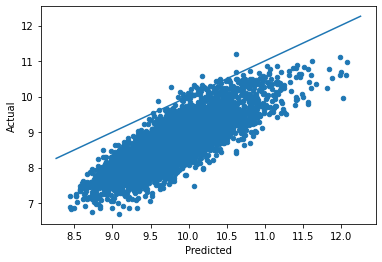

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm

xbar = np.exp(result.y).sum(['m','i']).to_dataframe('xbar').replace(0,np.nan).squeeze()
xhat = result.get_predicted_expenditures().sum(['m','i']).to_dataframe('xhat').replace(0,np.nan).squeeze()

# Make dataframe of actual & predicted
df = pd.DataFrame({'Actual':np.log(xbar),'Predicted':np.log(xhat)})

df.plot.scatter(x='Predicted',y='Actual')

# Add 45 degree line
v = plt.axis()
vmin = np.max([v[0],v[2]])
vmax = np.max([v[1],v[3]])
plt.plot([vmin,vmax],[vmin,vmax])

### Saving Result



You can save the estimated result, using something like



In [11]:
result.to_dataset('icrisat.ds')

<xarray.Dataset>
Dimensions:           (j: 8522, i: 42, k: 14, t: 4, m: 1, kp: 14)
Coordinates:
  * j                 (j) int64 10001 10002 10003 10004 ... 379151 379154 379155
  * t                 (t) int64 2010 2012 2015 2018
  * m                 (m) int64 1
  * i                 (i) object '(Cocoyam, Spinach, etc)' ... 'Yam-roots'
  * k                 (k) <U7 'M 0-3' 'M 4-8' 'M 9-13' ... 'F 31-50' 'F 51+'
  * kp                (kp) <U7 'M 0-3' 'M 4-8' 'M 9-13' ... 'F 31-50' 'F 51+'
Data variables: (12/20)
    alpha             object None
    beta              (i) float64 0.2647 0.4927 0.334 ... 0.328 0.3716 0.31
    delta             (k, i) float64 -0.01694 0.03455 ... 0.06678 0.08949
    prices            object None
    characteristics   (k, j, t, m) float64 0.0 1.0 1.0 1.0 ... nan nan nan 0.0
    loglambdas        (j, t, m) float64 -0.3283 1.068 0.3338 ... nan nan nan
    ...                ...
    se_beta           object None
    se_alpha          object None
    se_a              (i, t, m) float64 0.05958 0.05604 ... 0.02325 0.0213
    y                 (i, j, t, m) float64 nan nan nan nan ... nan nan nan nan
    logp              object None
    z                 (k, j, t, m) float64 0.0 1.0 1.0 1.0 ... nan nan nan 0.0